In [1]:
import collections
import glob
import itertools
import json
import operator
import os
import re

import _jsonnet
import IPython.display
import natsort
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#%matplotlib inline
#plt.rcParams['figure.figsize'] = [20, 20]
sns.set(color_codes=True)

from seq2struct.utils import evaluation
from seq2struct.utils import registry
from seq2struct import datasets

In [2]:
os.chdir('..')

# Procedure
1. Identify all checkpoints that we had selected
  - Snapshots that maximize sentence BLEU, exact match
  - Idiom models: across all contains-hole/none, cov-examples/cov-xent, 10/20/40/80
  - Baseline: across all evaluated steps for one model
2. Determine when and where idioms were output while decoding
3. Compute teacher-forced precision/recall
4. When the baseline gets it wrong and the model gets it right

# Finding checkpoints for idiom models

In [3]:
def find_idiom_checkpoints():
    accuracy_per_run = collections.defaultdict(dict)
    all_metrics = []
    metric_types = set()
    rows = []
    for d in sorted(glob.glob('logdirs/20190201-hs-allmatches-anysplit-multimean/*')):
        exp_name = os.path.basename(d)
        exp_vars = re.match('filt-([^_]+)_st-([^_]+)_nt-([^_]+)', exp_name).groups()

        infer_paths = glob.glob(os.path.join(d, 'infer-val-step*-bs1.jsonl'))
        all_scores = []
        for infer_path in infer_paths:
            step = int(re.search('step(\d+)', infer_path).group(1))
            _, metrics = evaluation.compute_metrics(
                'configs/hearthstone/nl2code.jsonnet', '', 'val', infer_path)
            all_scores.append((step, metrics['exact match']))
            all_metrics.append((exp_name, step, metrics))
            metric_types.update(metrics.keys())

        all_scores.sort(key=operator.itemgetter(0))
        sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
        rows.append(exp_vars + (len(all_scores),) + (sorted_scores[0] if sorted_scores else (-1, -1)))
        accuracy_per_run[exp_name] = {
            'x': [s[0] for s in all_scores],
            'all': [s[1] for s in all_scores],
        }
        print(d)

    metric_types = tuple(sorted(metric_types))
    df = pd.DataFrame(rows, columns=('filt', 'cov', 'nt', 'num steps eval', 'step', 'exact match'))
    flat_df = pd.DataFrame(
        [(exp_name, step) + tuple(metrics.get(t) for t in metric_types) for exp_name, step, metrics in all_metrics],
        columns=('exp_name', 'step') + metric_types)
    
    return flat_df

In [4]:
idiom_df = find_idiom_checkpoints()
print(idiom_df.loc[idiom_df['corpus BLEU'].idxmax()])
print(idiom_df.loc[idiom_df['exact match'].idxmax()])

logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-10
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-20
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-40
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-xent_nt-10
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-xent_nt-20
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-xent_nt-40
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-xent_nt-80
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-none_st-cov-examples_nt-10
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-none_st-cov-examples_nt-20
logdirs/20190201-hs-allmatches-anysplit-multimean/filt-none_st-cov-examples_nt-40
logdirs/20190201-hs-allmatches-anysplit-mu

# Finding checkpoints for baseline models

In [5]:
def find_baseline_checkpoints():
    accuracy_per_run = collections.defaultdict(dict)
    all_metrics = []
    metric_types = set()
    rows = []
    for d in sorted(glob.glob('logdirs/20181231-nl2code-hearthstone-fef2c5b//*')):
        exp_name = os.path.basename(d)
        exp_vars = re.match('att([^_]+)', exp_name).groups()

        infer_paths = glob.glob(os.path.join(d, 'infer-val-step*-bs1.jsonl'))
        all_scores = []
        for infer_path in infer_paths:
            step = int(re.search('step(\d+)', infer_path).group(1))
            _, metrics = evaluation.compute_metrics(
                'configs/hearthstone/nl2code.jsonnet', '', 'val', infer_path)
            all_scores.append((step, metrics['exact match']))
            all_metrics.append((exp_name, step, metrics))
            metric_types.update(metrics.keys())

        all_scores.sort(key=operator.itemgetter(0))
        sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
        rows.append(exp_vars + (len(all_scores),) + (sorted_scores[0] if sorted_scores else (-1, -1)))
        accuracy_per_run[exp_name] = {
            'x': [s[0] for s in all_scores],
            'all': [s[1] for s in all_scores],
        }
        print(d)

    metric_types = tuple(sorted(metric_types))
    df = pd.DataFrame(rows, columns=('att', 'num steps eval', 'step', 'exact match'))
    flat_df = pd.DataFrame(
        [(exp_name, step) + tuple(metrics.get(t) for t in metric_types) for exp_name, step, metrics in all_metrics],
        columns=('exp_name', 'step') + metric_types)
    
    return flat_df

In [6]:
baseline_df = find_baseline_checkpoints()
print(baseline_df.loc[baseline_df['corpus BLEU'].idxmax()])
print(baseline_df.loc[baseline_df['exact match'].idxmax()])

logdirs/20181231-nl2code-hearthstone-fef2c5b/att0
logdirs/20181231-nl2code-hearthstone-fef2c5b/att1
exp_name             att1
step                 1900
corpus BLEU      0.789029
exact match      0.151515
sentence BLEU    0.780316
Name: 44, dtype: object
exp_name             att1
step                 2300
corpus BLEU      0.762964
exact match       0.19697
sentence BLEU    0.766753
Name: 37, dtype: object


# Loading ground truth data

In [7]:
import ast
import astor 

val_data = registry.construct(
    'dataset', json.loads(_jsonnet.evaluate_file('configs/hearthstone/nl2code.jsonnet'))['data']['val']) 
test_data = registry.construct(
    'dataset', json.loads(_jsonnet.evaluate_file('configs/hearthstone/nl2code.jsonnet'))['data']['test']) 

normalized_gold_code_val = [astor.to_source(ast.parse(item.code)) for item in val_data]
normalized_gold_code_test = [astor.to_source(ast.parse(item.code)) for item in test_data]

# Determining when and where idioms were output during decoding

In [8]:
idiom_exact_match_max = idiom_df.loc[idiom_df['exact match'].idxmax()]

idiom_exact_match_infer_val_history_path = \
    'logdirs/20190201-hs-allmatches-anysplit-multimean/{}/infer-{}-step{:05d}-bs1-with-history.jsonl'.format(
        idiom_exact_match_max['exp_name'], 'val', idiom_exact_match_max['step'])

!CUDA_VISIBLE_DEVICES= python infer.py \
    --config configs/hearthstone-idioms/nl2code-0201-allmatches-anysplit-multimean.jsonnet \
    --logdir logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80 \
    --config-args "{filt: 'contains-hole', st: 'cov-examples', nt: 80}" \
    --output-history \
    --output __LOGDIR__/infer-val-step02200-bs1-with-history.jsonl --step 2200 --section val --beam-size 1

idiom_exact_match_infer_test_history_path = \
    'logdirs/20190201-hs-allmatches-anysplit-multimean/{}/infer-{}-step{:05d}-bs1-with-history.jsonl'.format(
        idiom_exact_match_max['exp_name'], 'test', idiom_exact_match_max['step'])

!CUDA_VISIBLE_DEVICES= python infer.py \
    --config configs/hearthstone-idioms/nl2code-0201-allmatches-anysplit-multimean.jsonnet \
    --logdir logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80 \
    --config-args "{filt: 'contains-hole', st: 'cov-examples', nt: 80}" \
    --output-history \
    --output __LOGDIR__/infer-test-step02200-bs1-with-history.jsonl --step 2200 --section test --beam-size 1

Output file logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80/infer-val-step02200-bs1-with-history.jsonl already exists
Output file logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80/infer-test-step02200-bs1-with-history.jsonl already exists


In [24]:
all_rules = json.load(
    open('data/hearthstone-idioms-20190201/all-matches-trees-anysplit/filt-contains-hole_st-cov-examples_nt-80/nl2code/grammar_rules.json')
)['all_rules']

def count_nodes(tree):
    queue = collections.deque([tree])
    count = 0
    while queue:
        node = queue.pop()
        count += 1 
        if isinstance(node, dict):
            for k, v in node.items():
                if k == '_type':
                    continue
                if isinstance(v, (list, tuple)):
                    queue.extend(v)
                else:
                    queue.append(v)
    return count

def analyze_idiom_usage(infer_history_path, normalized_gold_code):
    inferred_all = [json.loads(line) for line in open(infer_history_path)]
    exact_match_all = [
        normalized_gold_code[i] == example['beams'][0]['inferred_code'] if example['beams'] else False
        for i, example in enumerate(inferred_all)
    ]
    
    decoding_history_all = {}
    for example in inferred_all:
        decoding_history = []
        decoding_history_all[example['index']] = decoding_history
        if not example['beams']:
            continue

        for choice in example['beams'][0]['choice_history']:
            if isinstance(choice, int):
                decoding_history.append(all_rules[choice])
            else:
                decoding_history.append(choice)
                
    # Number of idioms used per program
    num_idioms_used_all = {}
    for i, history in decoding_history_all.items():
        counter = collections.Counter()
        for choice in history:
            if isinstance(choice, list) and isinstance(choice[1], str) and re.match('Template\d+', choice[1]):
                counter[tuple(choice)] += 1
        num_idioms_used_all[i] = counter
    
    # Size of each program
    # 1. Number of characters
    # 2. Number of lines
    # 3. Number of nodes in tree
    num_characters_all = {example['index']: len(example['beams'][0]['inferred_code']) if example['beams'] else 0 for example in inferred_all}
    num_lines_all      = {example['index']: example['beams'][0]['inferred_code'].count('\n') if example['beams'] else 0 for example in inferred_all}
    num_nodes_all      = {example['index']: count_nodes(example['beams'][0]['model_output']) if example['beams'] else 0 for example in inferred_all}
    
    # Dataframe
    idiom_usage_df = pd.DataFrame(collections.OrderedDict((
        ('Number of idioms used', {k: sum(v.values()) for k, v in num_idioms_used_all.items()}),
        ('Number of characters', num_characters_all),
        ('Number of lines', num_lines_all),
        ('Number of AST nodes', num_nodes_all),
        ('Exact match', dict(enumerate(exact_match_all))),
    )))
    exact_match_idiom_usage_df = idiom_usage_df[idiom_usage_df['Exact match']]
    
    fig, ax = plt.subplots()
    sns.distplot(idiom_usage_df['Number of idioms used'], kde=False, ax=ax, label='All')
    
    fig, ax = plt.subplots()
    sns.distplot(exact_match_idiom_usage_df['Number of idioms used'], kde=False, ax=ax, bins=5, label='Exact match')
    

    for x, y in (
        ('Number of characters', 'Number of idioms used'),
        ('Number of AST nodes', 'Number of idioms used')
    ):
#        fig, ax = plt.subplts
#        plt.plot(x, y, data=idiom_usage_df)
        jg = sns.jointplot(x=x, y=y, data=idiom_usage_df)
        jg.fig.suptitle('All')
        
        jg = sns.jointplot(x=x, y=y, data=exact_match_idiom_usage_df)
        jg.fig.suptitle('Exactly matched')
    
        
#        sns.jointplot(x='Number of characters', y='Number of idioms used', data=idiom_usage_df),
#        sns.jointplot(x='Number of characters', y='Number of idioms used', data=exact_match_idiom_usage_df),
#        sns.jointplot(x='Number of lines', y='Number of idioms used', data=idiom_usage_df),
#        sns.jointplot(x='Number of lines', y='Number of idioms used', data=exact_match_idiom_usage_df),
#        sns.jointplot(x='Number of AST nodes', y='Number of idioms used', data=idiom_usage_df),
#        sns.jointplot(x='Number of AST nodes', y='Number of idioms used', data=exact_match_idiom_usage_df),
#    ]:
        

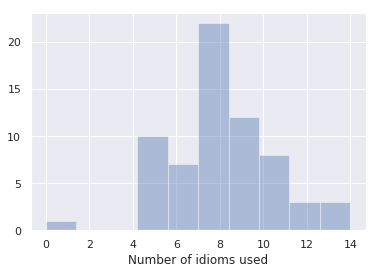

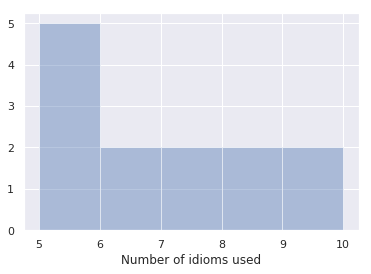

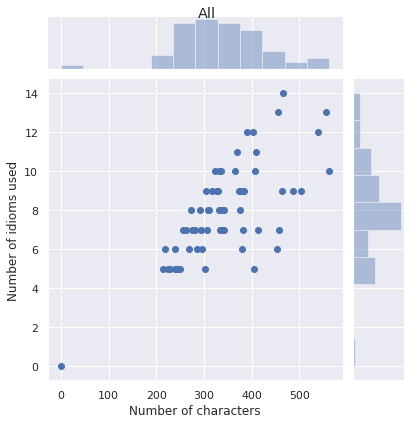

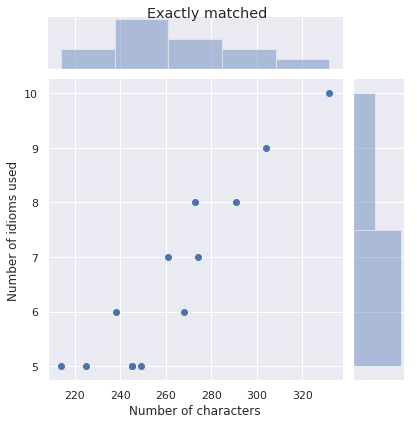

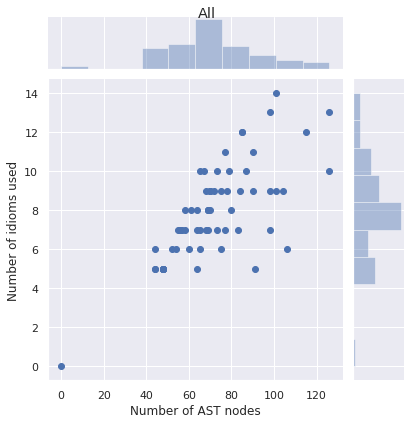

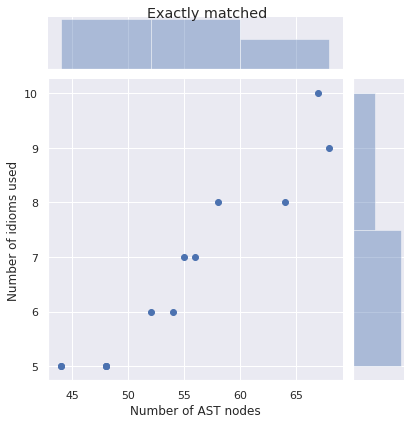

In [56]:
analyze_idiom_usage(idiom_exact_match_infer_val_history_path, normalized_gold_code_val)

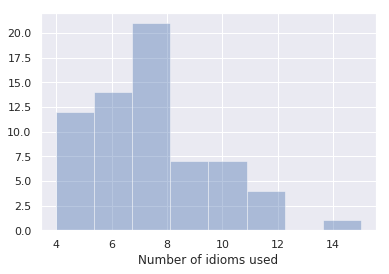

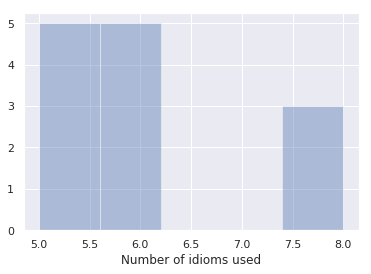

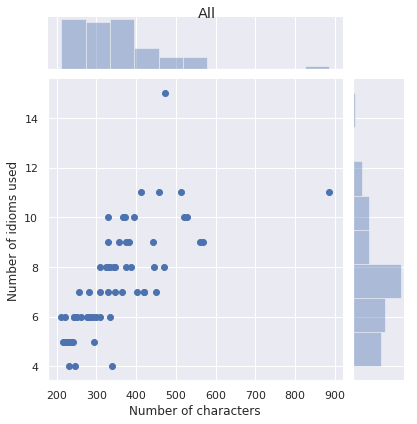

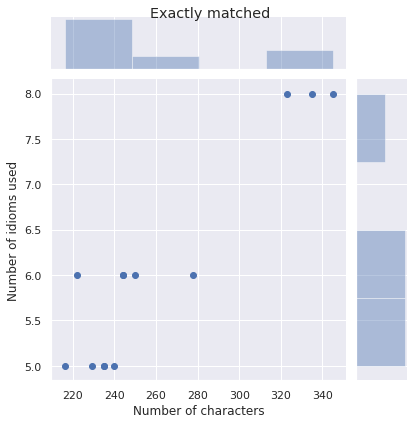

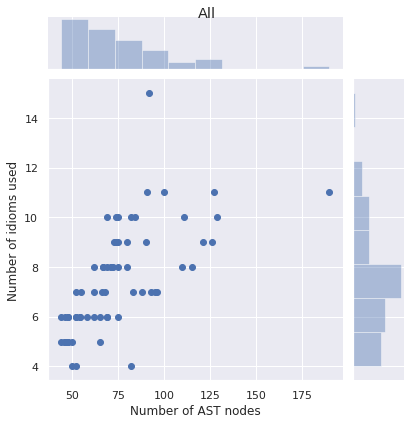

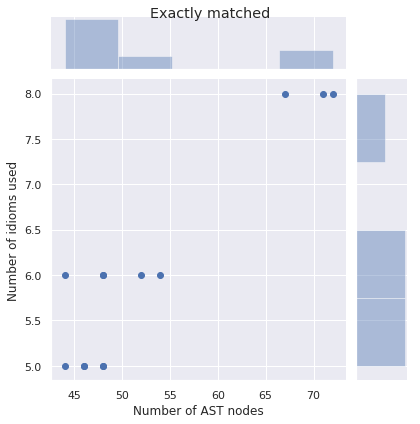

In [57]:
analyze_idiom_usage(idiom_exact_match_infer_test_history_path, normalized_gold_code_test)

# Teacher-forced precision and recall

In [63]:
def analyze_teacher_forced_pr(report, templates, accuracy_ks=(1, 2), precision_ks=(1, 2), recall_ks=(1, 2)):
    # Count how often 
    template_match_counts = collections.defaultdict(int)
    template_choice_ranks = {
        'all': collections.defaultdict(list),
        'templates only': collections.defaultdict(list),        
    }
    template_valid_choice_ranks = {
        'all': collections.defaultdict(list),
        'templates only': collections.defaultdict(list),
    }
    min_valid_ranks = []
    
    for item in report:
        for entry in item['history']:
            if not isinstance(entry['choices'][0], str):
                continue
            
            all_ranks = {}
            template_only_ranks = {}
            
            template_only_i = 0
            for i, choice in enumerate(entry['choices']):
                all_ranks[choice] = i
                template_only_ranks[choice] = template_only_i
                if not re.match('Template(\d+).*', choice):
                    template_only_i += 1
            
            # For overall top-k accuracy
            min_valid_rank = min(all_ranks[choice] for choice in entry['valid_choices'])
            min_valid_ranks.append(min_valid_rank)
            
            # For precision
            #   times that choice appeared at rank k, when it was valid (template_valid_choice_ranks)
            # / times that choice appeared at rank k (tp + fp), whether or not valid (template_choice_ranks)
            for choice in entry['choices']:
                m = re.match('Template(\d+).*', choice)
                if not m:
                    continue
                template_id = int(m.group(1))
                template_choice_ranks['all'][template_id].append(all_ranks[choice])
                template_choice_ranks['templates only'][template_id].append(template_only_ranks[choice])
                
            # For recall
            #   times that choice appeared at rank k, when it was valid (template_valid_choice_ranks)
            # / times that choice was valid (tp + fn)
            for choice in entry['valid_choices']:                
                m = re.match('Template(\d+).*', choice)
                if not m:
                    continue
                template_id = int(m.group(1))
                template_match_counts[template_id] += 1
                
                # Determine its rank
                template_valid_choice_ranks['all'][template_id].append(all_ranks[choice])
                # Determine its rank, excluding other templates
                template_valid_choice_ranks['templates only'][template_id].append(template_only_ranks[choice])

    min_valid_ranks = np.array(min_valid_ranks)
    # Top-k accuracy: there exists a valid choice such that its rank ≤ k
    top_k_accuracy = {
        k: np.sum(min_valid_ranks < k) / len(min_valid_ranks) for k in accuracy_ks
    }
    
    # Precision:
    #   Among the # of times that a given template has rank ≤ k, 
    #   how often it is a valid choice
    top_k_precision = {
        type_name: {
            k: {i: np.sum(np.array(template_valid_choice_ranks[type_name][i]) < k) /
                   np.sum(np.array(template_choice_ranks[type_name][i]) < k)
                for i in template_match_counts.keys()} for k in precision_ks
        } for type_name in template_valid_choice_ranks
    }
    
    # Recall:
    #   Among the # of times that a given template is a valid choice,
    #   how often it is a choice with rank ≤ k
    top_k_recall = {
        type_name: {
            k: {i: np.sum(np.array(ranks) < k) / len(ranks) for i, ranks in ranks_of_type.items()} for k in recall_ks
        } for type_name, ranks_of_type in template_valid_choice_ranks.items()}

    accuracy_df = pd.DataFrame({
        'Accuracy @ {}'.format(k): [top_k_accuracy[k]]
        for k in accuracy_ks
    })
    pr_df = pd.DataFrame({
        'Head': {t['id']: t['idiom'][0] for t in templates},
        'Matches': template_match_counts, 
        **{
            'Precision @ {} {}'.format(k, type_name): top_k_precision[type_name][k]
            for type_name in top_k_precision.keys()
            for k in precision_ks
        },
        **{
            'Recall @ {} {}'.format(k, type_name): top_k_recall[type_name][k]
            for type_name in top_k_recall.keys()
            for k in recall_ks
        }
    })
    return accuracy_df, pr_df

def analyze_anysplit_one(name, section):
    report = [json.loads(line)
              for line
              in open('../logdirs/20190201-hs-allmatches-anysplit/{}/debug-{}-step2600.jsonl'.format(name, section))]
    templates = json.load(open('../data/hearthstone-idioms-20190201/all-matches-trees-anysplit/{}/templates.json'.format(name)))
    return analyze(report, templates)

In [61]:
idiom_exact_match_debug_val_path = \
    'logdirs/20190201-hs-allmatches-anysplit-multimean/{}/debug-{}-step{:05d}.jsonl'.format(
        idiom_exact_match_max['exp_name'], 'val', idiom_exact_match_max['step'])

!CUDA_VISIBLE_DEVICES= python infer.py \
    --mode debug \
    --config configs/hearthstone-idioms/nl2code-0201-allmatches-anysplit-multimean.jsonnet \
    --logdir logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80 \
    --config-args "{filt: 'contains-hole', st: 'cov-examples', nt: 80}" \
    --output __LOGDIR__/debug-val-step02200.jsonl --step 2200 --section val --beam-size 1

idiom_exact_match_debug_test_path = \
    'logdirs/20190201-hs-allmatches-anysplit-multimean/{}/debug-{}-step{:05d}.jsonl'.format(
        idiom_exact_match_max['exp_name'], 'test', idiom_exact_match_max['step'])

!CUDA_VISIBLE_DEVICES= python infer.py \
    --mode debug \
    --config configs/hearthstone-idioms/nl2code-0201-allmatches-anysplit-multimean.jsonnet \
    --logdir logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80 \
    --config-args "{filt: 'contains-hole', st: 'cov-examples', nt: 80}" \
    --output-history \
    --output __LOGDIR__/debug-test-step02200.jsonl --step 2200 --section test --beam-size 1

WARNING <class 'seq2struct.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'seq2struct.models.enc_dec.EncDecModel'>: superfluous {'encoder_preproc': {'max_count': 5000, 'min_freq': 3, 'save_path': 'data/hearthstone-idioms-20190201/all-matches-trees-anysplit/filt-contains-hole_st-cov-examples_nt-80/nl2code/'}, 'decoder_preproc': {'max_count': 5000, 'min_freq': 3, 'grammar': {'name': 'idiom_ast', 'all_sections_rewritten': True, 'template_file': 'data/hearthstone-idioms-20190201/all-matches-trees-anysplit/filt-contains-hole_st-cov-examples_nt-80/templates.json', 'base_grammar': {'name': 'python'}}, 'save_path': 'data/hearthstone-idioms-20190201/all-matches-trees-anysplit/filt-contains-hole_st-cov-examples_nt-80/nl2code/', 'use_seq_elem_rules': True}}
Loading model from logdirs/20190201-hs-allmatches-anysplit-multimean/filt-contains-hole_st-cov-examples_nt-80/model_checkpoint-00002200
100%|███████████████████████████████████████████| 66/66 [00:12<00:00, 

In [78]:
templates = json.load(
    open('data/hearthstone-idioms-20190201/all-matches-trees-anysplit/{}/templates.json'.format(idiom_exact_match_max['exp_name'])))
accuracy_df_val, pr_df_val = analyze_teacher_forced_pr([json.loads(line) for line in open(idiom_exact_match_debug_val_path)], templates)

/home/richard/.local/share/virtualenvs/seq2s/lib/python3.5/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in long_scalars


In [79]:
accuracy_df_val

,Accuracy @ 1,Accuracy @ 2
0,0.960128,0.985008


In [80]:
pr_df_val

,Head,Matches,Precision @ 1 all,Precision @ 1 templates only,Precision @ 2 all,Precision @ 2 templates only,Recall @ 1 all,Recall @ 1 templates only,Recall @ 2 all,Recall @ 2 templates only
0,Module,6.0,NaN,NaN,NaN,0.090909,0.000000,0.000000,0.000000,1.000000
1,Module,11.0,0.714286,0.714286,0.714286,0.166667,0.454545,0.454545,0.454545,1.000000
2,Module,4.0,1.000000,1.000000,1.000000,0.060606,0.750000,0.750000,0.750000,1.000000
3,ClassDef,41.0,1.000000,1.000000,0.621212,0.546667,0.097561,0.097561,1.000000,1.000000
4,Module,66.0,1.000000,1.000000,1.000000,1.000000,0.833333,0.984848,1.000000,1.000000
5,ClassDef-body,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,FunctionDef,12.0,1.000000,1.000000,1.000000,0.139535,0.166667,0.250000,0.250000,1.000000
7,FunctionDef,67.0,NaN,NaN,NaN,0.531746,0.000000,0.000000,0.000000,1.000000
8,FunctionDef,18.0,1.000000,1.000000,1.000000,0.126761,0.166667,0.222222,0.333333,1.000000
9,Expr,7.0,NaN,1.000000,1.000000,0.127273,0.000000,0.571429,0.571429,1.000000


In [74]:
accuracy_df_test, pr_df_test = analyze_teacher_forced_pr([json.loads(line) for line in open(idiom_exact_match_debug_test_path)], templates)

/home/richard/.local/share/virtualenvs/seq2s/lib/python3.5/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in long_scalars


In [75]:
accuracy_df_test

,Accuracy @ 1,Accuracy @ 2
0,0.937904,0.971863


In [76]:
pr_df_test

,Head,Matches,Precision @ 1 all,Precision @ 1 templates only,Precision @ 2 all,Precision @ 2 templates only,Recall @ 1 all,Recall @ 1 templates only,Recall @ 2 all,Recall @ 2 templates only
0,Module,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Module,1.0,0.500000,0.500000,0.500000,0.015385,1.000000,1.000000,1.000000,1.000000
2,Module,3.0,1.000000,1.000000,1.000000,0.046154,0.333333,0.333333,0.333333,1.000000
3,ClassDef,42.0,1.000000,1.000000,0.646154,0.583333,0.023810,0.023810,1.000000,1.000000
4,Module,65.0,1.000000,1.000000,1.000000,1.000000,0.938462,0.984615,0.984615,1.000000
5,ClassDef-body,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,FunctionDef,10.0,1.000000,1.000000,1.000000,0.120482,0.100000,0.200000,0.200000,1.000000
7,FunctionDef,63.0,NaN,NaN,NaN,0.516393,0.000000,0.000000,0.000000,1.000000
8,FunctionDef,15.0,0.500000,0.750000,0.857143,0.111111,0.066667,0.200000,0.400000,1.000000
9,Expr,3.0,NaN,NaN,NaN,0.061224,0.000000,0.000000,0.000000,1.000000


# Comparing versus baseline

In [9]:
def load_inferred(infer_history_path, normalized_gold_code):
    inferred_all = [json.loads(line) for line in open(infer_history_path)]
    exact_match_all = [
        normalized_gold_code[i] == example['beams'][0]['inferred_code'] if example['beams'] else False
        for i, example in enumerate(inferred_all)
    ]
    
    return inferred_all, exact_match_all

In [10]:
print(baseline_df.loc[baseline_df['exact match'].idxmax()])

exp_name             att1
step                 2300
corpus BLEU      0.762964
exact match       0.19697
sentence BLEU    0.766753
Name: 37, dtype: object


In [11]:
!CUDA_VISIBLE_DEVICES= python infer.py \
    --config configs/hearthstone/nl2code.jsonnet \
    --logdir logdirs/20181231-nl2code-hearthstone-fef2c5b/att1 \
    --output __LOGDIR__/infer-test-step02300-bs1.jsonl --step 2300 --section test --beam-size 1

baseline_exact_match_infer_test_path = 'logdirs/20181231-nl2code-hearthstone-fef2c5b/att1/infer-test-step02300-bs1.jsonl'

Output file logdirs/20181231-nl2code-hearthstone-fef2c5b/att1/infer-test-step02300-bs1.jsonl already exists


In [12]:
inferred_test, exact_match_test = load_inferred(idiom_exact_match_infer_test_history_path, normalized_gold_code_test)
baseline_inferred_test, baseline_exact_match_test = load_inferred(baseline_exact_match_infer_test_path, normalized_gold_code_test)

In [16]:
comparison_df = pd.DataFrame({'Idioms': exact_match_test, 'Baseline': baseline_exact_match_test})
comparison_df[comparison_df.Baseline != comparison_df.Idioms]

,Baseline,Idioms
7,False,True
10,True,False
17,False,True
31,False,True
36,False,True


In [29]:
from seq2struct import grammars
idiom_config = json.loads(_jsonnet.evaluate_file(
        'configs/hearthstone-idioms/nl2code-0201-allmatches-anysplit-multimean.jsonnet',
        tla_codes={'args': "{filt: 'contains-hole', st: 'cov-examples', nt: 80}"}))
idiom_grammar = registry.construct('grammar', idiom_config['model']['decoder_preproc']['grammar'])

In [45]:
import pprint
for i in comparison_df[comparison_df.Baseline != comparison_df.Idioms].index:
    print('#{}\nGold:\n{}\nIdioms:\n{}\nBaseline:\n{}'.format(
        i, normalized_gold_code_test[i], 
        inferred_test[i]['beams'][0]['inferred_code'],
        baseline_inferred_test[i]['beams'][0]['inferred_code']))
    
    templates_used = set()
    actions = []
    for choice in inferred_test[i]['beams'][0]['choice_history']:
        if isinstance(choice, int):
            rule = all_rules[choice]
            actions.append(rule)
            if isinstance(rule[1], str) and re.match('Template\d+', rule[1]):
                templates_used.add(rule[1])
        else:
            actions.append(choice)
    if i == 36:
        print('Idiom actions:\n{}\n'.format(pprint.pformat(actions)))
    
    print('Templates used:')
    for t in natsort.natsorted(templates_used):
        cons = idiom_grammar.ast_wrapper.constructors[t]
        tree = cons.template({
            i: ['<HOLE-{}>*'.format(i)] if field.seq else '<HOLE-{}>'.format(i)
            for i, field in enumerate(cons.fields)}
        )
        print(t)
        pprint.pprint(tree)
    print('---')

#7
Gold:
class MagmaRager(MinionCard):

    def __init__(self):
        super().__init__('Magma Rager', 3, CHARACTER_CLASS.ALL, CARD_RARITY
            .FREE)

    def create_minion(self, player):
        return Minion(5, 1)

Idioms:
class MagmaRager(MinionCard):

    def __init__(self):
        super().__init__('Magma Rager', 3, CHARACTER_CLASS.ALL, CARD_RARITY
            .FREE)

    def create_minion(self, player):
        return Minion(5, 1)

Baseline:
class MagmaRager(MinionCard):

    def __init__(self):
        super().__init__('Magma Rager', 3, CHARACTER_CLASS.ALL, CARD_RARITY
            .FREE, False)

    def create_minion(self, player):
        return Minion(5, 1)

Templates used:
Template4
{'_extra_types': [],
 '_type': 'Module',
 'body': [{'_extra_types': [],
           '_type': 'ClassDef',
           'bases': [{'_extra_types': [], '_type': 'Name', 'id': '<HOLE-1>'}],
           'body': [{'_extra_types': [],
                     '_type': 'FunctionDef',
                    